Procesando frame 240/240, motion 34.43 rad

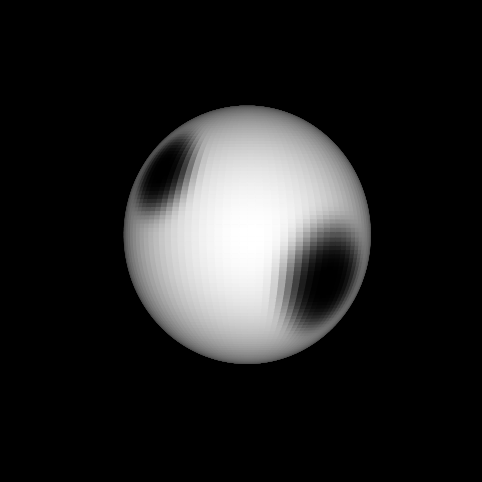

In [6]:
%matplotlib inline
#libraries
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.constants import R_sun
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from sklearn.preprocessing import normalize
import astropy.units as u
import os
from PIL import Image


os.makedirs("frames", exist_ok=True)#-------->creating folder to save the PNG

#functions 

# convertion function 
def convertion_radians(degree):
    return np.deg2rad(degree)

#function to calculate angular velocity    
def spot_theta(rotation_period, spot_colatitude, relative_shear):
    """
    Parameters:
    - rotation_period: rotation period of the sta
    - initial_latitude: latitud of spot(radians)
    - relative_shear: parameter between pole and equator
    Returns:
    - angular velocity.
    """
    latitude = np.pi / 2 - spot_colatitude #------->the spehre latitude is from 0  to 2pi, so in equator the colatitude will be pi?2
    angular_vel_equa= 2*np.pi*u.rad/rotation_period
    angular_velocity = angular_vel_equa*(1-relative_shear*np.sin(latitude)**2)
    return angular_velocity  

#flux function
def flux_plot(flux):
    ''' Function take a list normalizing the flux, converting the list in a csv file and rename the columns
    and return a plot    
    '''
    flux_norm = normalize([flux], norm="max")[0]
    df = pd.DataFrame(flux_norm)
    df.to_csv("lc_high.csv")
    lc = pd.read_csv("lc_high.csv")
    lc = lc.rename(columns={'Unnamed: 0': 'Days', '0': 'flux_normalized'})#-----> change the name of the columns
    lc.to_csv('lc_high_name.csv')
    return lc.plot(x="Days", y="flux_normalized", alpha=0.5)#----->simple plot of lc


# limb darkening function 
def limbdarkening(u):
    '''calculate a limb darkening lineal and put it to the spehre'''
    return (1 - u * (1 - mu))

#limb darkening quadratic     
def quadratic(u):
    """
    Calculates the intensity of a given cell in the stellar surface using a
    quadratic limb-darkening law.
  """

    return (1 - u * (1 - mu) - u * (1 - mu) ** 2)

#limb darkening logarithmic
def logarithmic(u):
    """
    Calculates the intensity of a given cell in the stellar surface using a
    logarithmic limb-darkening law.
    """
    
    return (1 - u * (1 - mu) - u * mu * np.log(mu) ** 2)



#function that create a gaussian mask to represent spots
def spot_mask(theta_mesh, spot_theta_rad,phi_mesh,spot_phi_rad,spot_radius_rad):
    '''function for creating spot mask, that could change the size and shape of the spot
    using a gaussian function
    '''
    delta_theta = np.arccos(np.cos(theta_mesh - spot_theta_rad.value))
    delta_phi = np.abs(phi_mesh - spot_phi_rad)
    distance_squared = delta_theta**2 + delta_phi**2
    sigma_squared = (spot_radius_rad / 2)**2
    return np.exp(-distance_squared**2 / (2* sigma_squared))

def spot_mask_binary(theta_mesh, spot_theta_rad, phi_mesh, spot_phi_rad, spot_radius_rad):
    """Máscara binaria: 1 dentro del radio de la mancha, 0 fuera"""
    delta_theta = np.arccos(np.cos(theta_mesh - spot_theta_rad.value))
    delta_phi = np.abs(phi_mesh - spot_phi_rad)
    distance_squared = delta_theta**2 + delta_phi**2
    return np.where(distance_squared <= spot_radius_rad**2, 1, 0)

def spot_mask_hard(theta_mesh, spot_theta_rad, phi_mesh, spot_phi_rad, radius_rad):
    delta_theta = np.arccos(np.cos(theta_mesh - spot_theta_rad.value))
    delta_phi = np.abs(phi_mesh - spot_phi_rad)
    distance_squared = delta_theta**2 + delta_phi**2
    return np.where(distance_squared <= radius_rad**2, 1.0, 0.0)

##function that creates spots

def add_spots(latitude_deg, longitude_deg, radii_deg):

    colatitude_rad = np.deg2rad(90 - latitude_deg)
    longitude_rad = np.deg2rad(longitude_deg)
    radii_rad = np.deg2rad(radii_deg)
    ang_vel = spot_theta(rotation_period, colatitude_rad, 0.2)  

    spots.append({
        'theta': longitude_rad * u.rad,
        'phi': colatitude_rad,
        'radius': radii_rad,
        'angular_velocity': ang_vel
    })




#animation Function
#@profile
def animate(i, gray_texture, mu,theta_mesh, phi_mesh,
            x, y, z, ax_sphere, elev, azim, total_frames):#ax_curve, line_curve, fluxes, total_frames):
    """ Function where is created the motion and call functions"""




    ax_sphere.clear()
    ax_sphere.set_axis_off()
    ax_sphere.view_init(elev=elev, azim=azim)
    texture = np.copy(gray_texture)




    for spot in spots:
        theta_mov = spot['theta'] + spot['angular_velocity'] * i * cadence_time.to(u.day)
        mask = spot_mask(theta_mesh, theta_mov, phi_mesh, spot['phi'], spot['radius'])
        texture *= (1 -  mask)  # Add texture to spot

    



    # Plot surface

    surf = ax_sphere.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=plt.cm.gray(texture), shade=False)


    print(f"Procesando frame {i+1}/{total_frames}, motion {theta_mov:.2f}",  end='\r')  # -------> to see the process
    # Png saves
    filename = f"frames/frame_{i:03d}.png"
    plt.savefig(filename, dpi=150, bbox_inches='tight', pad_inches=0)

    

    return[surf]

if __name__ == '__main__':
    
    # Stellar parameters 
    r = 1* u.R_sun
    res = 100#--->resolution
    constant = 0.8  # limb darkening coefficient
    rotation_period = 1* u.day #--->rotation period of the star
    
    # Point of view of the sphere
    elev = 0
    azim = 0
    
     #list of spots
    spots = []
    
    #adding spots
    add_spots(30, 45, 10)
    add_spots(-20, 90, 15)
    add_spots(0, 180, 20)

    
    #parameters of how many days periods
    observing_baseline_days = 5* u.day#----> Observation time
    cadence_time = 30 * u.minute#----> Cadence
    
    # frames
    total_frames = (observing_baseline_days / cadence_time).decompose().value
    total_frames = int(total_frames) 
    
    #Parameter of differential rotation
    relative_shear_coeff = 0.2
    
    #creating angles
    theta = np.linspace(0, 2*np.pi, res)
    phi = np.linspace(0, np.pi, res)
    
    #meshgrid for creation of the sphere surface
    theta_mesh, phi_mesh = np.meshgrid(theta, phi)
    
    x = r * np.sin(phi_mesh) * np.cos(theta_mesh)
    y = r * np.sin(phi_mesh) * np.sin(theta_mesh)
    z = r * np.cos(phi_mesh)
    
    # gray texture 
    gray_texture = np.ones((res, res))  # intensity white==1
    
    #convertion paraneters
    elev_rad = convertion_radians(elev)
    azim_rad = convertion_radians(azim)
    
    v_x = np.cos(elev_rad) * np.cos(azim_rad)
    v_y = np.cos(elev_rad) * np.sin(azim_rad)
    v_z = np.sin(elev_rad)
    
    # Limb darkening
    mu = (x * v_x + y * v_y + z * v_z) / r
    mu = np.clip(mu, 0, 1)
    
    lineal_darkening = limbdarkening(constant)
    gray_texture *= lineal_darkening
      
    # Figure
    plt.style.use('dark_background')# -----> dark background
    fig = plt.figure(figsize=(12, 6))
    ax_sphere = fig.add_subplot(projection='3d') 

    ax_sphere.set_box_aspect((0.98, 1, 0.95))#-------> symtries of the sun 
 
    ax_sphere.set_axis_off()
    
    
    for i in range(total_frames):
        animate(i, gray_texture, mu,theta_mesh, phi_mesh, x, y, z, ax_sphere, elev, azim, total_frames)
        plt.savefig(f"frames/frame_{i:03d}.png", dpi=300)




### Taking the images and making a mean of intensity

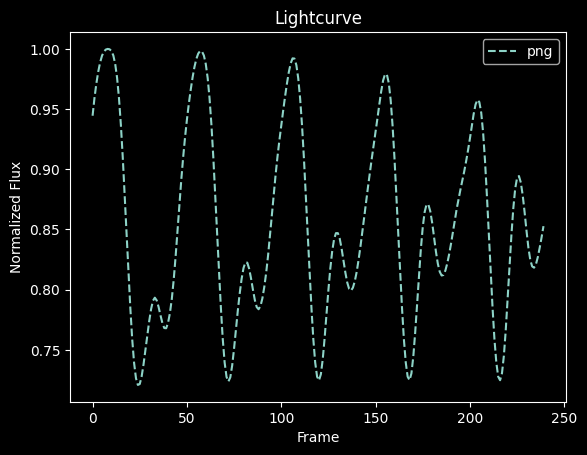

In [8]:
from PIL import Image
import numpy as np
import glob

# getting the frames
frame_files = sorted(glob.glob("frames/frame_*.png"))

# creating a list of the new fluxes
fluxes = []

for filename in frame_files:
    # convert images in gray scale
    img = Image.open(filename).convert('L')  # 'L' = 8-bit pixels, black and white
    img_array = np.array(img, dtype=np.float64)

    # Calculate intensities
    flux_total = np.sum(img_array)
    fluxes.append(flux_total)
fluxes_normalized_png = normalize([fluxes], norm="max")[0]
plt.plot(fluxes_normalized_png, label='png', linestyle='--')
plt.xlabel("Frame")
plt.ylabel("Normalized Flux")
plt.legend()
plt.title("Lightcurve")
plt.show()

### creating a gif again

In [3]:

# pathway to folder
frames_folder = "frames"
frame_files = sorted([f for f in os.listdir(frames_folder) if f.endswith('.png')])#--->i don't know this code was a god's revelation

# loading images
images = [Image.open(os.path.join(frames_folder, f)) for f in frame_files]

# Crear GIF
images[0].save("star_rotation.gif", format='GIF',
               append_images=images[1:],
               save_all=True,
               duration=80,  # 
               loop=0)  




Creating mp4 video